In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvPath = "data/"
file    = "cpu_utilization_asg_misconfiguration.csv"
df_cpu  = pd.DataFrame(pd.read_csv(csvPath + file))


In [2]:
print(df_cpu.head())

             timestamp   value
0  2014-05-14 01:14:00  85.835
1  2014-05-14 01:19:00  88.167
2  2014-05-14 01:24:00  44.595
3  2014-05-14 01:29:00  56.282
4  2014-05-14 01:34:00  36.534


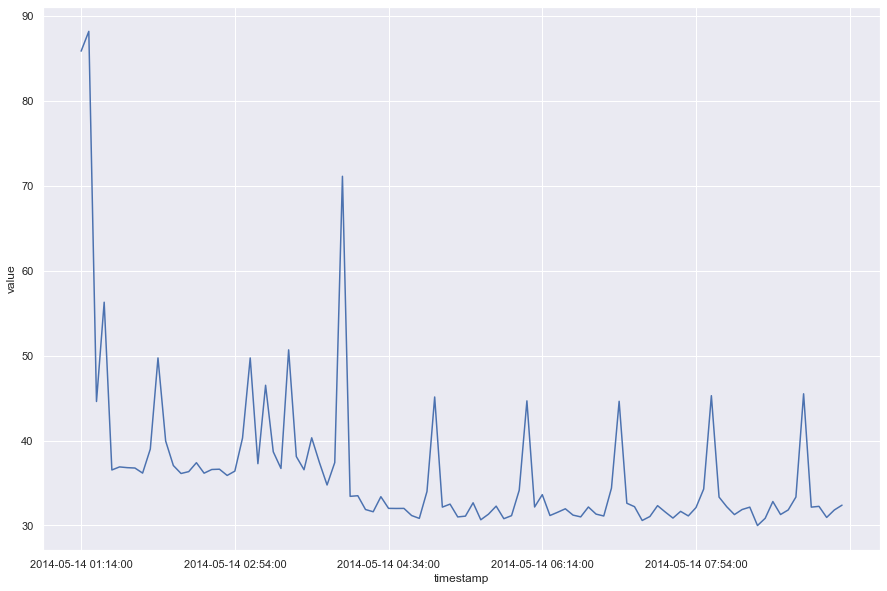

In [3]:
import matplotlib.ticker as ticker
plt.figure(figsize=(15, 10))
sns.set(style="darkgrid")
sns.lineplot(x="timestamp", y="value",
             data=df_cpu.head(100))
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))


Okay, simple plotting can identify the abnormal peak, now let's apply some model to automatically detect the outliers.

# Data Split

I am going to apply 2 unsupervised models: Ioslated Forest and Local Outlier Factor, and 2 supervised models: Random forest and One-class SVM. For data splitting, I am going to define the abnormal data point to be those with value outside range [mean-3*delta, mean+3*delta], then split the data into 70% of training data, and 30% testing. 

For performance measurement, I am going to use F1 score instead of accuracy because the ratio of "abnormal point" should be small.

In [4]:
m = df_cpu['value'].mean()
delta = df_cpu['value'].std()
X = np.array(df_cpu['value']).reshape(-1,1)
outlier_index = df_cpu.index[((df_cpu['value'] > m+3*delta) | (df_cpu['value'] < m-3*delta))].tolist()
X_outliers = np.array(df_cpu[((df_cpu['value'] > m+3*delta) | (df_cpu['value'] < m-3*delta))]['value']).reshape(-1,1)
y = np.ones(df_cpu.shape[0])
for i in outlier_index:
    y[i] = -1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

from sklearn.metrics import f1_score

# Using Isolation Forest

In [5]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
IF = IsolationForest(max_samples=100, behaviour="new", contamination = 0.1, random_state=rng)
IF.fit(X_train)

IF_pred_train = IF.predict(X_train)
IF_pred_test = IF.predict(X_test)
IF_pred_outliers = IF.predict(X_outliers)

print("training score: " + str(f1_score(y_train, IF_pred_train, average='binary')))
print("testing score: " + str(f1_score(y_test, IF_pred_test, average='binary')))
print("Is all outliers being identified? " + str(sum(IF_pred_outliers) + len(X_outliers) == 0))

training score: 0.9677227301722305
testing score: 0.9707336365434052
Is all outliers being identified? True


# Using LocalOutlierFactor

In [6]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
LOF.fit(X_train)

LOF_pred_train = LOF.predict(X_train)
LOF_pred_test = LOF.predict(X_test)
LOF_pred_outliers = LOF.predict(X_outliers)

print("training score: " + str(f1_score(y_train, LOF_pred_train, average='binary')))
print("testing score: " + str(f1_score(y_test, LOF_pred_test, average='binary')))
print("Is all outliers being identified? " + str(sum(LOF_pred_outliers) + len(X_outliers) == 0))

training score: 0.9364864864864866
testing score: 0.9246110889509374
Is all outliers being identified? False


# Using Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=rng)
RFC.fit(X_train, y_train)

RFC_pred_train = RFC.predict(X_train)
RFC_pred_test = RFC.predict(X_test)
RFC_pred_outliers = RFC.predict(X_outliers)

print("training score: " + str(f1_score(y_train, RFC_pred_train, average='binary')))
print("testing score: " + str(f1_score(y_test, RFC_pred_test, average='binary')))
print("Is all outliers being identified? " + str(sum(RFC_pred_outliers) + len(X_outliers) == 0))

training score: 1.0
testing score: 1.0
Is all outliers being identified? True


# Using One Class Support Vector Machine

In [8]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

clf_pred_train = clf.predict(X_train)
clf_pred_test = clf.predict(X_test)
clf_pred_outliers = clf.predict(X_outliers)

print("training score: " + str(f1_score(y_train, clf_pred_train, average='binary')))
print("testing score: " + str(f1_score(y_test, clf_pred_test, average='binary')))
print("Is all outliers being identified? " + str(sum(clf_pred_outliers) + len(X_outliers) == 0))

training score: 0.9999588019610266
testing score: 0.9999039477475747
Is all outliers being identified? False


Seem that Random forest did a perfect job, and one-class SVM is the only one that fails on identifying the outliers as defined. 